In [1]:
import torch
from torch import nn
from torchinfo import summary
import numpy as np

from tqdm import tqdm, trange

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST

import os
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from PIL import Image

np.random.seed(0)
torch.manual_seed(0)

In [ ]:
class ADNIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Get a list of subdirectories (labels) in the root directory
        self.labels = sorted(os.listdir(root_dir))

        # Create a mapping from label (subdirectory) to an integer
        self.label_to_idx = {label: idx for idx, label in enumerate(self.labels)}

        self.data = []
        self.targets = []
        self.names = []

        # Create a dictionary to store the count of images for each class
        self.class_counts = {label: 0 for label in self.labels}

        # Iterate through subdirectories
        for label in self.labels:
            label_dir = os.path.join(root_dir, label)
            
            # Check if it's a directory
            if not os.path.isdir(label_dir):
                continue

            # Get a list of image files in the subdirectory
            image_files = [f for f in os.listdir(label_dir) if f.lower().endswith((".jpg", ".jpeg", ".png", ".gif"))]

            # Update class counts and append image paths and their corresponding labels
            for image_file in image_files:
                image_path = os.path.join(label_dir, image_file)
                self.data.append(image_path)
                self.targets.append(self.label_to_idx[label])
                self.names.append(image_file)
                self.class_counts[label] += 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path = self.data[idx]
        image = Image.open(image_path)

        if self.transform:
            image = self.transform(image)

        label = self.targets[idx]
        name = self.names[idx]

        return image, label, name

    def get_class_counts(self):
        return self.class_counts
    
    def get_labels(self):
        return self.labels
    
    def get_names(self):
        return self.names

def create_dataloaders(dir, batch_size, shuffle=True, transform=None, num_workers=4):
    train_path = os.path.join(dir, "train")
    test_path = os.path.join(dir, "test")

    train_dataset = ADNIDataset(train_path, transform=transform)
    test_dataset = ADNIDataset(test_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, test_loader

In [2]:
PATCH_SIZE = 16 # P
IMAGE_WIDTH = 192
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 1
BATCH_SIZE = 64
NUM_HEADS = 6
NUM_LAYERS = 2
MLP_DROPOUT = 0.1
ATTN_DROPOUT = 0.0
EMBEDDING_DROPOUT = 0.1
MLP_SIZE = 768
NUM_CLASSES = 2

# EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2 # Hidden Size D
EMBEDDING_DIMS = 12
# NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2) # N

#the image width and image height should be divisible by patch size. This is a check to see that.
assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [3]:
train_transform = transforms.Compose([
    transforms.CenterCrop((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    # transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.CenterCrop((IMAGE_WIDTH, IMAGE_WIDTH)),
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
])

from dataset import basic_loader

train_loader = basic_loader(dir="D:/AD_NC/train", transform=train_transform, batch_size=BATCH_SIZE, shuffle=True)
test_loader = basic_loader("D:/AD_NC/test", transform=test_transform, batch_size=BATCH_SIZE, shuffle=False)

# train_loader, test_loader = create_dataloaders("D:/AD_NC", transform=transform, batch_size=BATCH_SIZE)
# train_data = datasets.ImageFolder(root="D:/AD_NC/train", transform=train_transform)
# test_data = datasets.ImageFolder(root="D:/AD_NC/test", transform=test_transform)

# train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
# test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# print(len(test_loader))
# print(train_loader.dataset.get_class_counts())
# print(test_loader.dataset.get_class_counts())

In [4]:
from modules import *
model = ViT(
        img_size=IMAGE_WIDTH,
        in_channels = IMAGE_CHANNELS,
        patch_size = PATCH_SIZE,
        embedding_dim = EMBEDDING_DIMS,
        num_transformer_layers = NUM_LAYERS, # from table 1 above
        mlp_dropout = MLP_DROPOUT,
        attn_dropout = ATTN_DROPOUT,
        embedding_dropout=EMBEDDING_DROPOUT,
        mlp_size = MLP_SIZE,
        num_heads = NUM_HEADS,
        num_classes = NUM_CLASSES)

summary(model=model,
        input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [64, 1, 192, 192]    [64, 2]              1,752                True
├─PatchEmbedding (patch_embedding)                           [64, 1, 192, 192]    [64, 144, 12]        --                   True
│    └─Conv2d (patcher)                                      [64, 1, 192, 192]    [64, 12, 12, 12]     3,084                True
│    └─Flatten (flatten)                                     [64, 12, 12, 12]     [64, 12, 144]        --                   --
├─Dropout (embedding_dropout)                                [64, 145, 12]        [64, 145, 12]        --                   --
├─Sequential (transformer_encoder)                           [64, 145, 12]        [64, 145, 12]        --                   True
│    └─TransformerEncoderBlock (0)                           [64, 145, 12]        [64, 145, 12] 

64
(1, 192, 192)


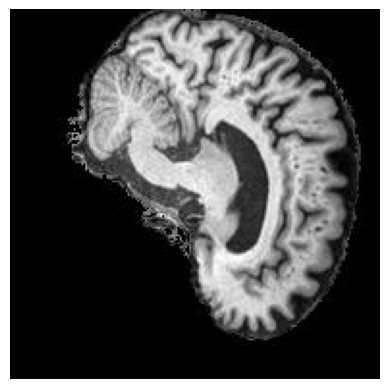

In [5]:
images, labels = next(iter(train_loader))
image = images[0]
imagesnp = images.numpy()
print(len(images))
print(imagesnp[0].shape)
# print(names[0])
plt.imshow(imagesnp[0][0], cmap='gray')
plt.axis("off")
plt.show()

In [ ]:
# conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

# # Pass the image through the convolution layer
# image_through_conv = conv_layer(image.unsqueeze(0))
# print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows, num_patch_cols embedding_dims]')

# # Permute the dimensions of image_through_conv to match the expected shape
# image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# # Create a flatten layer using nn.Flatten
# flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# # Pass the image_through_conv through the flatten layer
# image_through_conv_and_flatten = flatten_layer(image_through_conv)

# # Print the shape of the embedded image
# print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# # Assign the embedded image to a variable
# embedded_image = image_through_conv_and_flatten

In [ ]:
# class_token_embeddings = nn.Parameter(torch.rand((1, 1, EMBEDDING_DIMS), requires_grad  = True))
# print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

# embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
# print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

# position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
# print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

# final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
# print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

In [ ]:
# class PatchEmbeddingLayer(nn.Module):
#     def __init__(self, 
#                 in_channels, 
#                 patch_size, 
#                 embedding_dim,
#                 batch_size,
#                 n_patches):
#         super().__init__()
#         self.patch_size = patch_size
#         self.embedding_dim = embedding_dim
#         self.in_channels = in_channels
#         self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
#         self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
#         self.class_token_embeddings = nn.Parameter(torch.rand((batch_size, 1, embedding_dim), requires_grad=True))
#         self.position_embeddings = nn.Parameter(torch.rand((1, n_patches + 1, embedding_dim), requires_grad=True))

#     def forward(self, x):
#         output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings
#         return output

In [ ]:
# patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, 
#                                             patch_size=PATCH_SIZE, 
#                                             embedding_dim=EMBEDDING_DIMS,
#                                             batch_size=BATCH_SIZE,
#                                             n_patches=NUM_OF_PATCHES)
# patch_embeddings = patch_embedding_layer(images)
# patch_embeddings.shape

In [ ]:
# summary(model=patch_embedding_layer,
#         input_size=(BATCH_SIZE, 1, 192, 192), # (batch_size, input_channels, img_width, img_height)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# class MSABlock(nn.Module):
#   def __init__(self,
#             embedding_dims, # Hidden Size D in the ViT Paper Table 1
#             num_heads,  # Heads in the ViT Paper Table 1, this is number of 
#             attn_dropout # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
#             ):
#     super().__init__()

#     self.embedding_dims = embedding_dims
#     self.num_head = num_heads
#     self.attn_dropout = attn_dropout

#     self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

#     self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
#                                                     embed_dim = embedding_dims,
#                                                     dropout = attn_dropout,
#                                                     batch_first = True,
#                                                     )

#   def forward(self, x):
#     x = self.layernorm(x)
#     output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
#     return output

In [ ]:
# msa_block = MSABlock(embedding_dims = EMBEDDING_DIMS,
#                     num_heads = NUM_HEADS,
#                     attn_dropout=ATTN_DROPOUT
#                     )
# print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
# print(f'Shape of the output from MSA Block => {list(msa_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

In [ ]:
# summary(model=msa_block,
#         input_size=(64, NUM_OF_PATCHES+1, EMBEDDING_DIMS), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# class MLPBlock(nn.Module):
#   def __init__(self, embedding_dims, mlp_size, mlp_dropout):
#     super().__init__()
#     self.embedding_dims = embedding_dims
#     self.mlp_size = mlp_size
#     self.dropout = mlp_dropout

#     self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
#     self.mlp = nn.Sequential(
#         nn.Linear(in_features = embedding_dims, out_features = mlp_size),
#         nn.GELU(),
#         nn.Dropout(p = mlp_dropout),
#         nn.Linear(in_features = mlp_size, out_features = embedding_dims),
#         nn.Dropout(p = mlp_dropout)
#     )

#   def forward(self, x):
#     return self.mlp(self.layernorm(x))

In [ ]:
# mlp_block = MLPBlock(embedding_dims = EMBEDDING_DIMS,
#                 mlp_size = MLP_SIZE,
#                 mlp_dropout = MLP_DROPOUT)

# summary(model=mlp_block,
#         input_size=(1, NUM_OF_PATCHES+1, EMBEDDING_DIMS), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# class TransformerBlock(nn.Module):
#     def __init__(self, embedding_dims,
#                 mlp_dropout,
#                 attn_dropout,
#                 mlp_size,
#                 num_heads,
#                 ):
#         super().__init__()

#         self.msa_block = MSABlock(embedding_dims = embedding_dims,
#                                                     num_heads = num_heads,
#                                                     attn_dropout = attn_dropout)

#         self.mlp_block = MLPBlock(embedding_dims = embedding_dims,
#                                                         mlp_size = mlp_size,
#                                                         mlp_dropout = mlp_dropout,
#                                                         )
#     def forward(self,x):
#         x = self.msa_block(x) + x
#         x = self.mlp_block(x) + x

#         return x

In [ ]:
# transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
#                                     mlp_dropout = MLP_DROPOUT,
#                                     attn_dropout=ATTN_DROPOUT,
#                                     mlp_size = MLP_SIZE,
#                                     num_heads = NUM_HEADS)

# print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
# print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

In [ ]:
# summary(model=transformer_block,
#         input_size=(1, NUM_OF_PATCHES+1, EMBEDDING_DIMS), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [ ]:
# class ViT(nn.Module):
#     def __init__(self,
#                 in_channels,
#                 patch_size,
#                 n_patches,
#                 embedding_dims,
#                 num_transformer_layers,
#                 mlp_dropout,
#                 attn_dropout,
#                 mlp_size,
#                 num_heads,
#                 num_classes,
#                 batch_size):
#         super().__init__()

#         self.patch_embedding_layer = PatchEmbeddingLayer(in_channels=in_channels, 
#                                                         patch_size=patch_size, 
#                                                         embedding_dim=embedding_dims,
#                                                         batch_size=batch_size,
#                                                         n_patches=n_patches)

#         self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
#                                                 mlp_dropout = mlp_dropout,
#                                                 attn_dropout = attn_dropout,
#                                                 mlp_size = mlp_size,
#                                                 num_heads = num_heads) for _ in range(num_transformer_layers)])

#         self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
#                                         nn.Linear(in_features = embedding_dims,
#                                                 out_features = num_classes))

#     def forward(self, x):
#         return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [ ]:
# model = ViT(in_channels = IMAGE_CHANNELS,
#         patch_size = PATCH_SIZE,
#         n_patches = NUM_OF_PATCHES,
#         embedding_dims = EMBEDDING_DIMS,
#         num_transformer_layers = NUM_LAYERS, # from table 1 above
#         mlp_dropout = MLP_DROPOUT,
#         attn_dropout = ATTN_DROPOUT,
#         mlp_size = MLP_SIZE,
#         num_heads = NUM_HEADS,
#         num_classes = NUM_CLASSES,
#         batch_size=BATCH_SIZE)

# summary(model=model,
#         input_size=(BATCH_SIZE, IMAGE_CHANNELS, IMAGE_HEIGHT, IMAGE_WIDTH), # (batch_size, num_patches, embedding_dimension)
#         col_names=["input_size", "output_size", "num_params", "trainable"],
#         col_width=20,
#         row_settings=["var_names"])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
N_EPOCHS = 20
LR = 0.005
optimizer = Adam(model.parameters(), 
                lr=LR)
                # weight_decay=0.3,
                # betas=(0.9, 0.999)) # Based on the paper
criterion = CrossEntropyLoss()

total_step = len(train_loader)

Using device:  cuda (NVIDIA GeForce RTX 3060 Laptop GPU)


In [ ]:
# # Construct scaler for mixed precision training
# scaler = torch.cuda.amp.GradScaler()
# train_accuracies = []
# test_accuracies = []
# train_losses = []
# test_losses = []

# # Training loop
# for epoch in trange(N_EPOCHS, desc="Training"):
#     train_loss = 0.0
#     correct = 0
#     total = 0
#     batch_num = 0
    
#     model.train()  # Set the model to training mode

#     for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1} in training", leave=False):
#         batch_num += 1
#         x, y = batch
#         x, y = x.to(device), y.to(device)

#         optimizer.zero_grad()

#         with torch.cuda.amp.autocast():
#             y_hat = model(x)
#             loss = criterion(y_hat, y)

#         scaler.scale(loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         train_loss += loss.item()
#         _, predicted = y_hat.max(1)
#         total += y.size(0)
#         correct += predicted.eq(y).sum().item()

#         # if (batch_num % 100 == 0):
#         #     print(f"Finished {batch_num} batches out of {len(train_loader)} batches")

#     accuracy = 100 * correct / total
#     print(f"Epoch {epoch + 1}/{N_EPOCHS} - Loss: {train_loss / len(train_loader):.4f}, Accuracy: {accuracy:.2f}%")
#     train_accuracies.append(accuracy)
#     train_losses.append(train_loss / len(train_loader))

#         # Test loop
#     with torch.no_grad():
#         correct, total = 0, 0
#         test_loss = 0.0
#         for batch in tqdm(test_loader, desc="Testing"):
#             x, y = batch
#             x, y = x.to(device), y.to(device)
#             y_hat = model(x)
#             loss = criterion(y_hat, y)
#             test_loss += loss.detach().cpu().item() / len(test_loader)

#             correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
#             total += len(x)
#         print(f"Test loss: {test_loss:.2f}")
#         print(f"Test accuracy: {correct / total * 100:.2f}%")
#         test_accuracies.append(correct / total * 100)
#         test_losses.append(test_loss)

In [ ]:
# # Test loop
# with torch.no_grad():
#     correct, total = 0, 0
#     test_loss = 0.0
#     for batch in tqdm(test_loader, desc="Testing"):
#         x, y = batch
#         x, y = x.to(device), y.to(device)
#         y_hat = model(x)
#         loss = criterion(y_hat, y)
#         test_loss += loss.detach().cpu().item() / len(test_loader)

#         correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
#         total += len(x)
#     print(f"Test loss: {test_loss:.2f}")
#     print(f"Test accuracy: {correct / total * 100:.2f}%")

In [7]:
from train import train

train_accuracies, valid_accuracies, train_losses, valid_losses = train(model=model,
        train_loader=train_loader,
        valid_loader=test_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        n_epochs=N_EPOCHS)

Training:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20 - Loss: 0.6947, Accuracy: 50.94%


Training:   5%|▌         | 1/20 [00:28<09:10, 28.96s/it]

Test loss: 0.70
Test accuracy: 49.24%


Epoch 2/20 - Loss: 0.6783, Accuracy: 58.19%


Training:  10%|█         | 2/20 [00:56<08:27, 28.19s/it]

Test loss: 0.73
Test accuracy: 45.95%


Epoch 3/20 - Loss: 0.6764, Accuracy: 57.91%


Training:  15%|█▌        | 3/20 [01:24<07:54, 27.90s/it]

Test loss: 0.73
Test accuracy: 47.62%


Epoch 4/20 - Loss: 0.6588, Accuracy: 60.57%


Training:  20%|██        | 4/20 [01:51<07:25, 27.85s/it]

Test loss: 0.71
Test accuracy: 49.89%


Epoch 5/20 - Loss: 0.6323, Accuracy: 65.49%


Training:  25%|██▌       | 5/20 [02:19<06:54, 27.66s/it]

Test loss: 0.75
Test accuracy: 53.54%


Epoch 6/20 - Loss: 0.6068, Accuracy: 68.06%


Training:  30%|███       | 6/20 [02:46<06:26, 27.59s/it]

Test loss: 0.74
Test accuracy: 54.80%


Epoch 7/20 - Loss: 0.5911, Accuracy: 69.39%


Training:  35%|███▌      | 7/20 [03:14<05:59, 27.64s/it]

Test loss: 0.75
Test accuracy: 54.19%


Epoch 8/20 - Loss: 0.5693, Accuracy: 71.14%


Training:  40%|████      | 8/20 [03:42<05:31, 27.65s/it]

Test loss: 0.77
Test accuracy: 55.92%


Epoch 9/20 - Loss: 0.5530, Accuracy: 72.69%


Training:  45%|████▌     | 9/20 [04:09<05:03, 27.63s/it]

Test loss: 0.77
Test accuracy: 56.04%


Epoch 10/20 - Loss: 0.5373, Accuracy: 74.15%


Training:  50%|█████     | 10/20 [04:37<04:36, 27.66s/it]

Test loss: 0.77
Test accuracy: 56.75%


Epoch 11/20 - Loss: 0.5150, Accuracy: 75.20%


Training:  55%|█████▌    | 11/20 [05:05<04:09, 27.78s/it]

Test loss: 0.78
Test accuracy: 58.02%


Epoch 12/20 - Loss: 0.5028, Accuracy: 76.51%


Training:  60%|██████    | 12/20 [05:33<03:41, 27.73s/it]

Test loss: 0.85
Test accuracy: 58.73%


Epoch 13/20 - Loss: 0.4914, Accuracy: 77.07%


Training:  65%|██████▌   | 13/20 [06:00<03:14, 27.74s/it]

Test loss: 0.82
Test accuracy: 56.54%


Epoch 14/20 - Loss: 0.4738, Accuracy: 78.18%


Training:  70%|███████   | 14/20 [06:28<02:46, 27.75s/it]

Test loss: 0.79
Test accuracy: 56.86%


Epoch 15/20 - Loss: 0.4715, Accuracy: 78.00%


Training:  75%|███████▌  | 15/20 [06:58<02:21, 28.33s/it]

Test loss: 0.80
Test accuracy: 58.69%


Epoch 16/20 - Loss: 0.4584, Accuracy: 79.04%


Training:  80%|████████  | 16/20 [07:28<01:55, 28.79s/it]

Test loss: 0.92
Test accuracy: 59.00%


Epoch 17/20 - Loss: 0.4540, Accuracy: 78.96%


Training:  85%|████████▌ | 17/20 [07:57<01:27, 29.01s/it]

Test loss: 0.86
Test accuracy: 57.56%


Epoch 18/20 - Loss: 0.4440, Accuracy: 79.72%


Training:  90%|█████████ | 18/20 [08:26<00:58, 29.04s/it]

Test loss: 0.84
Test accuracy: 59.62%


Epoch 19/20 - Loss: 0.4418, Accuracy: 79.77%


Training:  95%|█████████▌| 19/20 [08:54<00:28, 28.72s/it]

Test loss: 0.84
Test accuracy: 58.78%


Epoch 20/20 - Loss: 0.4243, Accuracy: 80.92%


Training: 100%|██████████| 20/20 [09:23<00:00, 28.19s/it]

Test loss: 0.92
Test accuracy: 58.55%


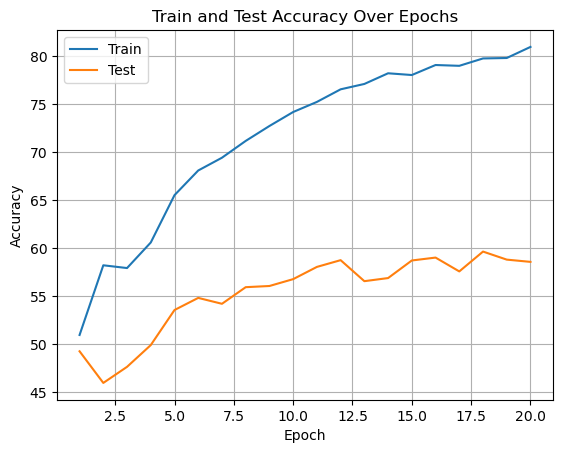

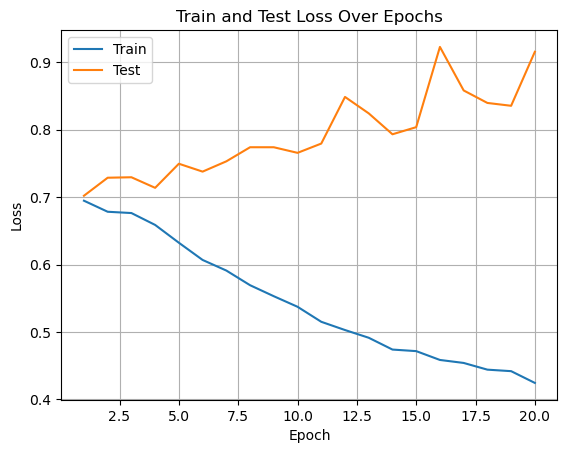

In [8]:
# import matplotlib.pyplot as plt

# def plot_data(train_data, 
#                     test_data, 
#                     heading,
#                     labels=None):
#     if labels is None:
#         labels = ['Train', 'Test']

#     # Check if the lengths of input lists match
#     if len(train_data) != len(test_data):
#         raise ValueError("Train and test accuracy lists must have the same length.")

#     # Create x-axis values (epochs)
#     epochs = range(1, len(train_data) + 1, 1)

#     # Plot train and test accuracies
#     plt.plot(epochs, train_data, label=labels[0])
#     plt.plot(epochs, test_data, label=labels[1])

#     # Set plot labels and legend
#     plt.xlabel('Epoch')
#     plt.ylabel(f'{heading}')
#     plt.legend(loc='best')

#     # Show the plot
#     plt.grid(True)
#     plt.title(f'{labels[0]} and {labels[1]} {heading} Over Epochs')
#     plt.show()

from utils import plot_data

plot_data(train_accuracies, valid_accuracies, labels=['Train', 'Test'], heading='Accuracy')
plot_data(train_losses, valid_losses, labels=['Train', 'Test'], heading='Loss')